# Riconoscimento audio semplice: riconoscimento di parole chiave

Questo notebook descrive come preelaborare file audio nel formato WAV e creare e allenare un [modello di riconoscimento vocale automatico di base](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) per **riconoscere dieci parole diverse**. Utilizzeremo una parte del [set di dati dei comandi vocali di Warden, 2018](https://www.tensorflow.org/datasets/catalog/speech_commands), che contiene brevi [**clip audio**](https://jworgit.blogspot.com/2016/05/cose-un-clip-multimediale.html) (di un secondo o meno) di comandi vocali come (ma non solo) "giù", "vai", "sinistra", "no", " destra", "stop", "su" e "sì".<br><br>
I sistemi di riconoscimento vocale e audio del mondo reale sono complessi. [Questo notebook](https://ai.googleblog.com/search/label/Speech%20Recognition) fornisce <u>una comprensione di base</u> delle tecniche coinvolte.<br><br>
Vedi anche [qui](https://www.tensorflow.org/tutorials/audio/simple_audio).

## Setup
Importiamo i moduli e le dipendenze necessari.<br><br> In questo notebook per la visualizazione dei dati / grafici utilizzeremo [*seaborn*](https://seaborn.pydata.org/).

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf              # prima 'pip install tensorflow' da un prompt anaconda

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


seed = 42                            # # impostiamo il seme per la riproducibilità
tf.random.set_seed(seed)             # a livello di tensorflow
np.random.seed(seed)                 # a livello di numpy

from IPython.display import Image    # per importare in una cella di tipo CODICE un'immagine

## Importazione dello mini-dataset *Speech Commands* 
Il dataset [*Speech Commands*](https://www.tensorflow.org/datasets/catalog/speech_commands) contiene oltre 105.000 file audio [*Waveform*](https://alexlacava.com/glossary/forma-d-onda/#:~:text=La%20forma%20d'onda%20%C3%A8,essere%20pi%C3%B9%20o%20meno%20complessa.) nel formato [*WAV*](https://it.wikipedia.org/wiki/Waveform_Audio_File_Format), con persone che pronunciano **35 parole diverse**.<br>Questo dataset è stato raccolto da Google:
* dimensione dello zip: 2.37 GB
* dimensione del dataset *unzipped*: 8.17 GB
* 3 partizioni: training (85511), validation (10102), test(4890).
<br>

Per risparmiare tempo nel caricamento dei dati, useremo una versione **più piccola** del dataset originale, costituita da sole **8000** brevi clip audio (<u>di un secondo o meno</u>) di <u>8 comandi</u>: "giù", "vai", "sinistra", "no", " destra", "stop", "su" e "sì" (1000 audio clip per comando).<br><br> 
Scarichiamo ed estraiamo il file <u>*mini_speech_commands.zip*</u> contenente i set di dati dei comandi vocali più piccoli con *tf.keras.utils.get_file*.

In [2]:
DATASET_PATH = 'data/mini_speech_commands'  # attenzione: creare questo path sul vostro disco (è la destinazione
                                            # dell'estrazione)

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():                   # se la directory NON esiste ancora (se esiste, si salta questa if)
  tf.keras.utils.get_file(                  # il comando keras di download del file
      'mini_speech_commands.zip',           # il nome dello zip da scaricato
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip", 
                                            # la url sorgente
      extract=True,                         # "True tries extracting the file as an Archive, like tar or zip"
      cache_dir='.', 
      cache_subdir='data')                  # crea le sotto-directory

In [3]:
data_dir                                    # la directory principale 

WindowsPath('data/mini_speech_commands')

Le clip audio del mini-dataset sono state archiviate in <u>otto cartelle</u> corrispondenti a ciascun comando vocale: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`. La cartella (e quindi la label) sono ricavate dal path del file.

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir))) # la lista delle sotto-directory
commands = commands[commands != 'README.md']
print('Commands:', commands)                            # la lista dei comandi vocali del mini-dataset

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Estraiamo le clip audio in una lista (meglio, un tensore di rango 1, cioè un vettore) chiamata `filenames`, **contenente tutti i loro *path/filename*** e mescoliamola (*shuffle*) in modo **casuale** (perchè le varie clip potrebbero essere correlate tra loro, cioè non-indipendenti):

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')      # caricamento della lista

In [6]:
tf.io.gfile.glob(str(data_dir) + '/*/*')                  # display della lista

['data\\mini_speech_commands\\right\\012c8314_nohash_1.wav',
 'data\\mini_speech_commands\\right\\0132a06d_nohash_1.wav',
 'data\\mini_speech_commands\\right\\0132a06d_nohash_2.wav',
 'data\\mini_speech_commands\\right\\0132a06d_nohash_3.wav',
 'data\\mini_speech_commands\\right\\0135f3f2_nohash_0.wav',
 'data\\mini_speech_commands\\right\\0137b3f4_nohash_1.wav',
 'data\\mini_speech_commands\\right\\0137b3f4_nohash_2.wav',
 'data\\mini_speech_commands\\right\\0137b3f4_nohash_3.wav',
 'data\\mini_speech_commands\\right\\01bb6a2a_nohash_0.wav',
 'data\\mini_speech_commands\\right\\01bb6a2a_nohash_1.wav',
 'data\\mini_speech_commands\\right\\01bb6a2a_nohash_3.wav',
 'data\\mini_speech_commands\\right\\01d22d03_nohash_0.wav',
 'data\\mini_speech_commands\\right\\0227998e_nohash_0.wav',
 'data\\mini_speech_commands\\right\\0362539c_nohash_1.wav',
 'data\\mini_speech_commands\\right\\037c445a_nohash_0.wav',
 'data\\mini_speech_commands\\right\\0397ecda_nohash_0.wav',
 'data\\mini_speech_comm

In [7]:
filenames = tf.random.shuffle(filenames)                  # la lista mescolata
num_samples = len(filenames)                              # la lunghezza della lista (il numero degli elementi)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])               # il primo path/filename (come esempio)

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\no\\e1aa22e4_nohash_0.wav', shape=(), dtype=string)


In [8]:
type(filenames)             # un tensore 2.0 (eager execution di TensorFlow 2.0 vs graph execution di TensorFlow 1.0) 

tensorflow.python.framework.ops.EagerTensor

In [9]:
filenames.shape             # un tensore di rango 1 (un vettore, cioè una lista appunto) di cardinalità 8000.

TensorShape([8000])

[Eager execution vs graph execution](https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6).

Dividiamo la lista `filenames` in un set di training, uno di validazione ed uno di test, rispettivamente con queste percentuali: 80:10:10.<br>
[Il dataset originale completo è già diviso nelle tre partizioni, come detto prima; il dataset ridotto, non ancora].<br><br>
Attenzione, durante i precedenti corsi abbiamo spesso utilizzato il termine *validazione* (*validation*) per intendere il dataset di test. Qui, invece, il dataset di validazione è un terzo, ulteriore, dataset, in genere usato per il **tuning degli iper-parametri** (di configurazione). Una volta scelto il miglior valore dello / degli iper-parametri (*hyper-parameters*), possiamo verificare le prestazioni predittive del modello su un altro dataset (quello di test). E' il modus operandi più sicuro [ESL - Hastie & Tibshirani].

In [10]:
train_files = filenames[:6400]           # le prime 6400 clip sono di training
val_files = filenames[6400: 6400 + 800]  # le clip da 6401 a 7200 sono di validazione 
test_files = filenames[-800:]            # le ultime 800 clip sono di test

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Lettura dei file audio e delle loro etichette (*label*)

Ora pre-elaboriamo il dataset, creando **tensori decodificati** per le forme d'onda (*waveform*) e le etichette corrispondenti. Si noti che:
* ciascun file WAV contiene una <u>serie temporale</u> con un determinato numero di campioni (*samples*) al secondo.<br><br>
* ogni campione rappresenta l'[ampiezza](https://en.wikipedia.org/wiki/Amplitude) del segnale audio in quel momento specifico.<br><br>
* in un [sistema a 16 bit](https://en.wikipedia.org/wiki/Audio_bit_depth), come appunto i file *WAV* del dataset *Mini Speech Commands*, i valori di ampiezza vanno da **-32.768 a 32.767**.<br><br>
* [la frequenza di campionamento](https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling) (*sample rate*) di questo dataset è **16kHz** [*vedi le prime 5 righe **TOP** e la **FIGURA** del link a Wikipedia EN*].<br>

Costruiamo un tensore decodificato, di nome `test_audio`, attraverso il metodo `tf.audio.decode_wav`, e la cui forma (*shape*) è `[samples, channels]`, dove `channels` è `1` per mono e `2` per stereo. Questo mini dataset contiene solo registrazioni mono (per questo motivo, la cardinalità della seconda dimensione del tensore è 1).<br><br>
[Un utile post](https://stackoverflow.com/questions/58096095/how-does-tf-audio-decode-wav-get-its-contents).<br>
[Un altro utile post](https://stackoverflow.com/questions/38902433/tensorflow-strings-what-they-are-and-how-to-work-with-them).

In [11]:
# esempio preliminare con una SINGOLA clip, come dimostrazione.

# passo 1: creazione di un tensore stringa:

# 'tf.audio.decode_wav()' richiede un tensore in input. Si può costruirlo con 'tf.io.read_file()', che legge 
# un file WAV e lo carica in un tensore di tipo STRINGA (perchè un path/file-name è una stringa!)

test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav') 
                            #  è la lettura di un singolo file WAV di label 'down'.
                            #  'test_file' è sempre comunque un EAGER TENSOR.

# passo 2: decodifica del tensore stringa

test_audio, _ = tf.audio.decode_wav(contents=test_file)
                            #  'test_audio' è ora un tensore decodificato (sempre di tipo eager).
                            #  '_' indica una variabile usa e getta ('tf.audio.decode_wav' produce infatti due output, il
                            #  secondo qui non rilevante).      

In [12]:
print(test_audio)           # --> il tensore stringa è stato trasformato in tensore (decodificato) di tipo `float32`, 
                            #     normalizzato nell'intervallo [-1.0, 1.0]. 
    
                            #     "NumPy arrays are stored as contiguous blocks of memory. They usually have a single datatype
                            #     (e.g. integers, floats or fixed-length strings) and then the bits in memory are interpreted 
                            #     as values with that datatype." (stackoverflow 29877508)
    
test_audio.shape            # --> 13654 si ottiene per moltiplicazione dei parametri visti (per questo file).

tf.Tensor(
[[0.00177002]
 [0.00299072]
 [0.00283813]
 ...
 [0.02526855]
 [0.02972412]
 [0.01776123]], shape=(13654, 1), dtype=float32)


TensorShape([13654, 1])

Questo per un singolo file WAV.<br><br>
Costruiamo ora una funzione di *pre-processing* (`decode_audio`) che operi la suddetta trasformazione e che possa essere richiamata in un loop od ancor meglio in modo vettorizzato (cioè in parallelo su tutti i file WAV).<br><br>
Un tensore decodicato è un **tensore audio**.

In [14]:
def decode_audio(audio_binary):
  # decodifica i file audio in formato WAV in tensori `float32`, normalizzati nell'intervallo [-1.0, 1.0]. 
  # restituisce audio `float32` e un sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # tutti i dati sono singolo canale (mono), si cancella quindi l'asse `channels` dall'array con il metodo 'tf.squeeze'.
  return tf.squeeze(audio, axis=-1)

**Nota tecnica su Jupyter**: l'editor visualizza in rosso le variabili (ed i commenti) che non sono indentati secondo gli
standard (4 spazi). [Vedi qui](https://stackoverflow.com/questions/35330872/why-are-some-variables-and-comments-in-my-ipython-notebook-red).

Definiamo ora una funzione (`get_label`) che ricava la label del file dalla sotto-directory del file stesso:
- *split* dei percorsi dei file (*pathname*) in `tf.RaggedTensor`, cioè tensori con sezioni di dimensione irregolare (*ragged dimensions slices*) che possono avere lunghezze diverse.

In [15]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Nota: qui usiamo l'indexing anzichè lo spacchettamento della tupla per permettere il funzionamento con un grafo di
  # TensorFlow.
  return parts[-2]

Definiamo infine una funzione (`get_waveform_and_label`), che mette tutto insieme (forma d'onda ed etichetta), richiamando le altre due funzioni prima definite:
* l'input è il *pathname* file audio *WAV*.
* l'output è una tupla contenente i tensori audio e le etichette.<br>

In [16]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)               # estrae la label dal path/file-name.
  audio_binary = tf.io.read_file(file_path)  # crea il tensore stringa.
  waveform = decode_audio(audio_binary)      # crea il tensore audio (decodificato).
  return waveform, label                     # restituisce il tensore audio (la waveform) e la label.

Siamo così pronti per l'apprendimento supervisionato.<br><br>
Costruiamo il training set, estraendo le coppie audio-etichette con le funzioni sopra definite, in due passi:
* creiamo un `tf.data.Dataset` (*files_ds*) con il metodo `Dataset.from_tensor_slices`
* e poi un `ParallelMapDataset` (*waveform_ds*), cioè un dataset potenzialmente di grandi dimensioni, con il metodo `Dataset.map`, utilizzando la funzione `get_waveform_and_label` (prima creata).<br>

Più avanti creeremo i set di validazione e di test utilizzando una procedura simile.


In [17]:
AUTOTUNE = tf.data.AUTOTUNE                # l'impostazione del numero di chiamate parallele

files_ds = tf.data.Dataset.from_tensor_slices(train_files)  
                                           # 'train_files' è il vettore dei path/file-name di training

waveform_ds = files_ds.map(                # --> si ottiene la raccolta delle waveform di TRAINING ('waveform_ds')
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [18]:
print(type(files_ds))      # il tensore stringa ottenuto
print(len(files_ds))       # la sua lunghezza
print(type(waveform_ds))   # il tensore audio ottenuto
print(len(waveform_ds))    # la sua lunghezza

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
6400
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
6400


Visualizziamo alcune *waveform* audio (9):

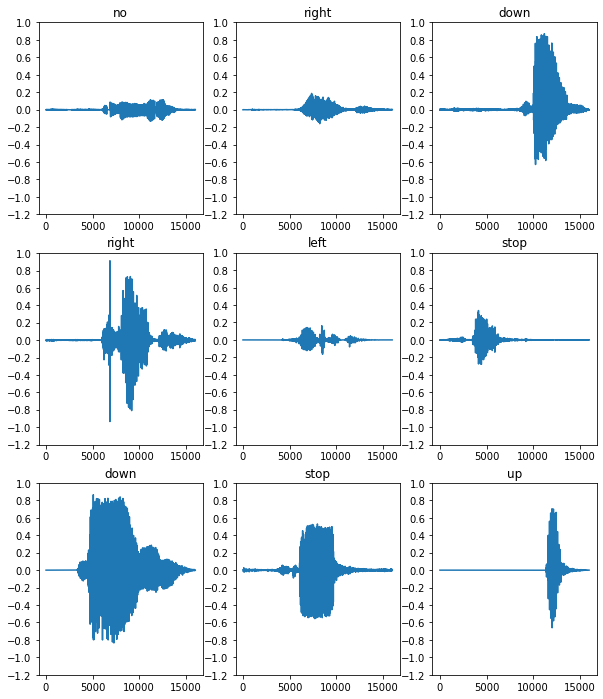

In [19]:
rows = 3
cols = 3
n = rows * cols   # 9 waveform 
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):   # loop sulle prime n waveform
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())                                   # il metodo 'numpy' applicato all'oggetto 'audio' lo converte 
                                                           # in formato numpy (nd-array), così da poterlo plottare.

  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()
                  # i pattern delle varie parole sono chiaramente riconoscibili.

## Conversione delle *waveforms* in *spettrogrammi*
Le forme d'onda (*waveform*) del dataset sono rappresentate secondo la dimensione **temporale**, come detto. Dobbiamo trasformarle da **segnali temporali** a **frequenze**, calcolando <u>la trasformata di Fourier</u> a breve termine ([STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)) e così convertendo le forme d'onda in [spettrogrammi](https://en.wikipedia.org/wiki/Spectrogram), che mostrano le variazioni di frequenza nel tempo e possono essere rappresentati come **<u>immagini 2D</u>**. 

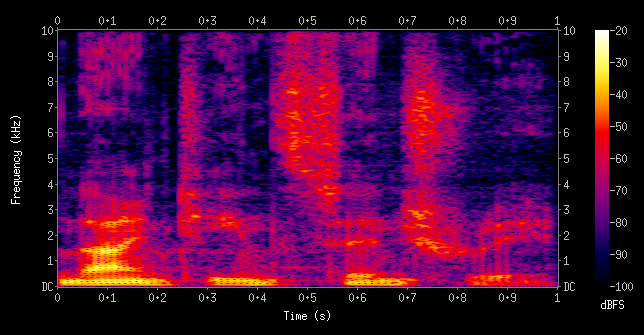

In [20]:
Image(filename='images/Spectrogram_19thC.png', width=800) # lo spettrogramma della frase "nineteenth century".
                                                          # In ordinata le frequenze crescenti verso l'alto, in ascissa
                                                          # il tempo. 
                                                          # La legenda a dx mostra l'intensità del colore, che cresce con la densità.
        

Quindi a ciascuna di queste immagini dello spettrogramma facciamo <u>attraversare la rete neurale</u> che abbiamo definito, per addestrarla.<br><br>
Una normale trasformata di Fourier (la funzione `tf.signal.fft`) converte un segnale nelle sue frequenze componenti, ma perde tutte le informazioni temporali. Invece, STFT (`tf.signal.stft`) divide il segnale in **finestre temporali** ed esegue una trasformata di Fourier <u>su ciascuna finestra</u>, preservando alcune informazioni temporali e restituendo un **tensore 2D**, sul quale è quindi possibile eseguire <u>**convoluzioni standard** (con una rete CNN)</u>.<br><br>
Creiamo quindi una <u>funzione</u> (`get_spectrogram`) per convertire una SINGOLA forma d'onda in uno spettrogramma:
* le forme d'onda devono essere della stessa lunghezza, in modo che, quando le si converte in spettrogrammi, i risultati abbiano dimensioni simili. Questo può essere fatto semplicemente riempiendo di zeri (*zero padding*) le clip audio che sono più brevi di un secondo (usando `tf.zeros`).
* quando si chiama `tf.signal.stft`, occorre impostare i parametri `frame_length` e `frame_step` in modo tale che l'**immagine** dello spettrogramma generato sia quasi quadrata. Per ulteriori informazioni sulla scelta dei parametri delle STFT vedi [questo video di *Coursera*](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) sull'elaborazione del segnale audio e STFT.
* STFT produce una matrice di numeri complessi che rappresentano l'ampiezza (*magnitude*)  e la fase (*phase*). Tuttavia, in questo notebook utilizziamo solo l'ampiezza, che si può ricavare applicando `tf.abs` all'output di `tf.signal.stft`.

In [21]:
# definizione di una funzione di trasformazione di una forma d'onda in uno spettrogramma con la STFT:

def get_spectrogram(waveform):

  # Zero-padding per le audio waveform con mneo di 16,000 esempi.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  
  # Conversione del dtype tensore waveform a float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  
  # Concatenazione della waveform con lo `zero_padding`, il che assicura che tutte le audio clips siano della stessa 
  # lunghezza.
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  # Conversione della waveform in un spettrogramma attraverso STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  
  # Ottenimento della magnitudine della STFT.
  spectrogram = tf.abs(spectrogram)
  
  # Aggiunta della dimensione 'canale', così che lo spettrogramma possa essere usato come un input di tipo IMMAGINE ai  
  # i livelli convolutivi della CNN (che si aspettano una 'shape' dei tensori del tipo (`batch_size`, `height`, `width`, 
  # `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
    
  return spectrogram

Iniziamo ora ad esplorare i dati (gli spettrogrammi).<br><br>
Visualizziamo le forme (*shapes*) della forma d'onda tensorizzata di **un esempio** e lo spettrogramma corrispondente, e poi riproduciamo l'audio originale:

In [26]:
for waveform, label in waveform_ds.take(1):      # estraiamo UNA waveform ed UNA label (la seconda) come ESEMPIO.
    label = label.numpy().decode('utf-8')        # la label estratta.
                                                 # la waveform estratta ci serve più avanti per il plot.
    spectrogram = get_spectrogram(waveform)      # lo spettrogramma corrispondente alla waveform.

print('Label:', label)
print('Waveform shape:', waveform.shape)         # le cardinalità delle dimensioni della waveform
print('Spectrogram shape:', spectrogram.shape)   # le cardinalità delle dimensioni delle spettrogramma.
print('Audio playback')
display.display(display.Audio(waveform, rate=16000)) 
                                                 # la funzione di PLAYBACK della waveform estratta (per curiosità)

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Ora definiamo una funzione (`plot_spectrogram`) per visualizzare uno spettrogramma di una *waveform*.

In [27]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    
  # Conversione delle frequenze alla scala logaritmica e trasposizione, così che il tempo sia rappresentato sulle asse X
  # (le colonne).
  # Aggiunta di una epsilon per evitare di prendere il log di zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Visualizziamo lungo l'asse temporale la forma d'onda dell'esempio di prima (<u>quella</u> *waveform* prima estratta) e lo spettrogramma corrispondente delle frequenze nel tempo (<u>quello</u> *spectogram* prima estratto):

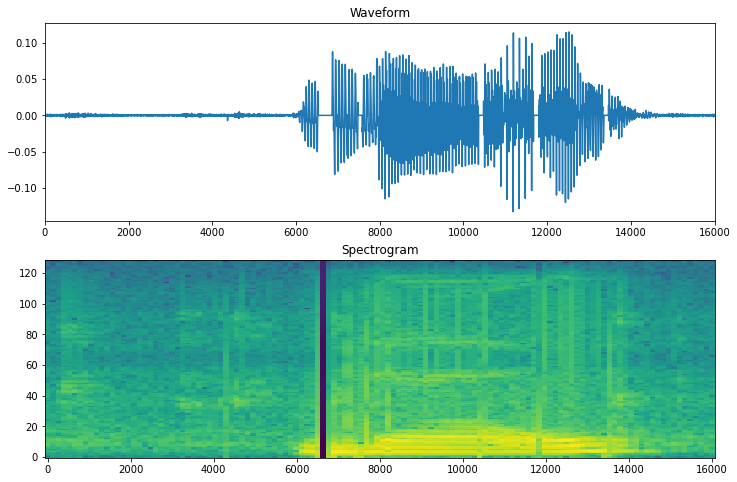

In [29]:
fig, axes = plt.subplots(2, figsize=(12, 8))    # divide lo schermo in due sotto-finestre (una per plot)

timescale = np.arange(waveform.shape[0])        # il set di valori di waveform da visualizzare (0 --> 15.999)

axes[0].plot(timescale, waveform.numpy())       # il metodo 'numpy' applicato all'oggetto 'waveform' lo converte in formato 
                                                # numpy (nd-array), così da poterlo plottare.
    
axes[0].set_title('Waveform')                   # il titolo del primo plot
axes[0].set_xlim([0, 16000])                    # i limiti dei valori dell'asse X

# il plot dello spettrogramma corrispondente:
plt.rcParams['pcolor.shading'] ='nearest'       # stackoverflow 65799736, per prevenire il seguente warning di 'matplotlib':
                                                # matplotlibdeprecationwarning: shading='flat' when x and y have the same 
                                                # dimensions as c is deprecated since 3.3.
        
plot_spectrogram(spectrogram.numpy(), axes[1])  # il metodo 'numpy' applicato all'oggetto 'spectrogram' lo converte in 
                                                # formato numpy (nd-array), così da poterlo plottare.
axes[1].set_title('Spectrogram')
plt.show()

Ora definiamo una funzione (`get_spectrogram_and_label_id`) che trasformi <u>sia</u> la forma d'onda in spettrogramma <u>che</u> le relative etichette in ID interi:

In [30]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Ed applichiamo questa funzione (`get_spectrogram_and_label_id`) a tutte le *waveform* di training (`waveform_ds`) con il metodo `Dataset.map`:

In [31]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

`spectrogram_ds` contiene l'elenco di tutti gli spettrogrammi del training set. E' un tensore di tipo `ParallelMapDataset`.<br><br>
Esaminiamo alcuni di questi spettrogrammi (i primi 9, come fatto prima con le *waveform*):

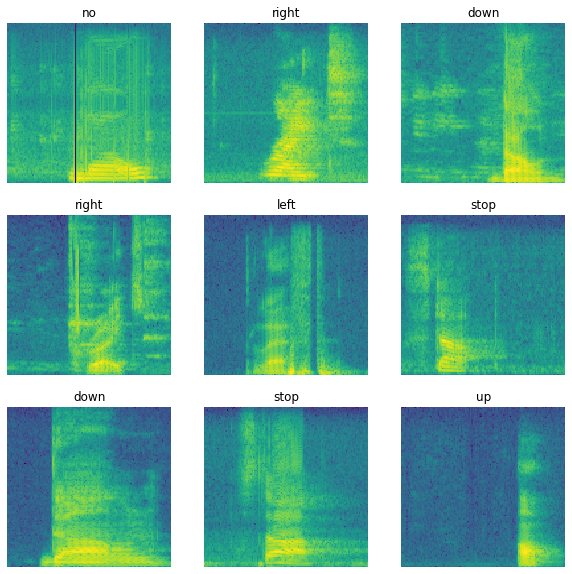

In [36]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):  # estrazione dalla raccolta degli spettrogrammi di 
                                                                      # training di n=9 esempi (e non più 1 come sopra)
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)   # il plot dello spettrogramma in formato numpy
  ax.set_title(commands[label_id.numpy()])    # la label corrispondente (stampata qui come titolo sopra lo spettrogramma)
  ax.axis('off')

plt.show()

## Costruzione ed allenamento del modello
Ripetiamo lo stesso pre-processing (fatto prima sul *training* set) anche sul *validation* e *test* set.<br><br>
A questo scopo, definiamo un'apposita funzione (`preprocess_dataset`) che trasforma il tensore con la lista dei file WAV in un tensore con gli spettrogrammi e le label intere.

In [37]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,       # la funzione 'get_waveform_and_label' restituisce il tensore audio (la 
                                             # waveform) e la label (estratta dal path-name del file audio) associati al 
                                             # file audio.
      
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id, # la funzione 'get_waveform_and_label_id' trasforma la waveform in 
                                             # spettrogramma e le relative etichette in ID interi. 
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [38]:
train_ds = spectrogram_ds                  # pre-processato già prima
val_ds = preprocess_dataset(val_files)     # 'val_files' contiene le clip da 6401 a 7200 di validazione (vedi sezione 1.2)
test_ds = preprocess_dataset(test_files)   # 'test_files' contiene le ultime 800 clip di test (vedi sezione 1.2)

Abbiamo così i tre dataset (composti di spettrogrammi e label).

In [39]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

6400
800
800


Lottizzazione (*batching*) del training e validation set per il training del modello:

In [40]:
batch_size = 64                            # per la scelta del miglior batch-size vedi le slide di 'Introduzione alle NN'
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [41]:
# le lunghezze aggiornate dei tre dataset:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

100
13
800


Utilizziamo i metodi `Dataset.cache` (vedi [qui](https://stackoverflow.com/questions/50519343/how-to-cache-data-during-the-first-epoch-correctly-tensorflow-dataset)) e `Dataset.prefetch` (vedi [qui](https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options)) per ridurre la latenza durante il training del modello:

In [42]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Poichè abbiamo prima trasformato i file audio in immagini spettrogramma, possiamo ora usare, come modello di rete, una semplice **convolutional neural network (CNN)**.<br><br>
Il modello `tf.keras.Sequential` usa i seguenti livelli *keras* di **pre-processing**:

- `tf.keras.layers.Resizing`: per <u>sottocampionare</u> l'input in modo da velocizzare il training del modello.
- `tf.keras.layers.Normalization`: per <u>normalizzare</u> ogni pixel dell'immagine in base alla sua media e deviazione standard [ogni pixel è infatti un vettore n-dimensionale! - cioè, una colonna del dataset].

Per quanto riguarda il livello `Normalization`, il suo metodo `adapt` richiede prima di essere chiamato sui dati di training, così da calcolare le statistiche aggregate (cioè, la media e la standard deviation).

In [43]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands) # per l'ultimo livello denso

print()

# Instanziazione ("costruzione") del layer `tf.keras.layers.Normalization`.
norm_layer = layers.Normalization()
# Fit dello stato del layer sullo spettrogramma con il metodo `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

# il COSTRUTTORE del modello:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Sotto-campionamento dell'input
    layers.Resizing(32, 32),
    # Normalizzazione
    norm_layer,
    # I livelli convolutivi
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    # Il livello di pooling
    layers.MaxPooling2D(),
    layers.Dropout(0.25),                  # tecnica di regolarizzazione per evitare l'overfitting.
    layers.Flatten(),                      # "l'appiattimento", perchè il classificatore ha bisogno di vettori piatti 
                                           # (mono-dimensionali).
    layers.Dense(128, activation='relu'),  # il livello denso (pienamente connesso): è il classificatore
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)          

Configuriamo ora il modello *Keras* con l'ottimizzatore **Adam** (una variante recente dell'algoritmo [*SGD*](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) che usa *learning rate* adattativi) e la loss function **cross-entropy** (aka, *negative log-likelihood*), tipica della classificazione multi-label:

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
                  # è la compilazione del grafo computazionale (di TensorFlow).
                  # è molto veloce.

Alleniamo ora il modello con 10 [epoche](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) (a scopo dimostrativo):<br>
[attenzione: la `val_accuracy` di ogni epoca è riportata a fine della prima riga ed a inizio della seconda riga]

In [45]:
EPOCHS = 10
history = model.fit(
    train_ds,                 # fit sul training set
    validation_data=val_ds,   # il dataset di validazione
                              # dall'help on-line: "Data on which to evaluate the loss and any model metrics at the end 
                              # of each epoch. The model will not be trained on this data. Thus, note the fact that the 
                              # validation loss of data provided using `validation_split` or `validation_data` is not 
                              # affected by regularization layers like noise and dropout."
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                              # dall'help on-line: "List of callbacks to apply during training.".
)
# NB. Se alcune celle precedenti (od anche questa) sono rieseguite, e quindi il seme pseudo-casuale è modificato rispetto  
# alla sequenza originaria delle celle, il fit può interrompersi prima dell'iterazione 10 per "early stopping".

Epoch 1/10
100/100 [==============================] - 6s 54ms/step - loss: 1.7288 - accuracy: 0.3691 - val_loss: 1.2893 - val_accuracy: 0.5788
Epoch 2/10
100/100 [==============================] - 4s 42ms/step - loss: 1.1495 - accuracy: 0.5967 - val_loss: 0.8952 - val_accuracy: 0.7088
Epoch 3/10
100/100 [==============================] - 4s 42ms/step - loss: 0.8959 - accuracy: 0.6802 - val_loss: 0.7828 - val_accuracy: 0.7362
Epoch 4/10
100/100 [==============================] - 4s 43ms/step - loss: 0.7310 - accuracy: 0.7412 - val_loss: 0.6818 - val_accuracy: 0.7638
Epoch 5/10
100/100 [==============================] - 4s 41ms/step - loss: 0.6555 - accuracy: 0.7672 - val_loss: 0.6224 - val_accuracy: 0.7925
Epoch 6/10
100/100 [==============================] - 4s 41ms/step - loss: 0.5753 - accuracy: 0.7978 - val_loss: 0.5757 - val_accuracy: 0.8100
Epoch 7/10
100/100 [==============================] - 4s 42ms/step - loss: 0.5083 - accuracy: 0.8164 - val_loss: 0.5248 - val_accuracy: 0.8313

Plottiamo le solite **curve di apprendimento**, qui le curve del loss del training e validation set, per verificare se il modello è migliorato durante l'addestramento:<br>

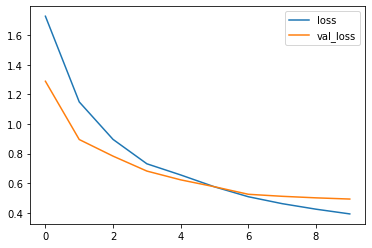

In [46]:
metrics = history.history                  # l'oggetto history include le callback
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Valutazione delle prestazioni predittive del modello
Ora, infine, eseguiamo il modello sui dati di **test** (`test_ds`) e verifichiamo le sue prestazioni predittive:

In [47]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
print(type(test_audio))
print(test_audio.size)
print(len(test_audio))
print(test_audio.shape)
print(test_audio.dtype)
print(test_audio)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1) # la previsione, una volta costruito il modello, è fatta sulle
                                                      # forme d'onda (e non sugli spettrogrammi)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

In [ ]:
model.predict(test_audio)

### Visualizzazione della matrice di confusione
Usiamo infine la solita matrice di confusione per verificare le prestazioni predittive (prima calcolate) in modo disaggregato. 

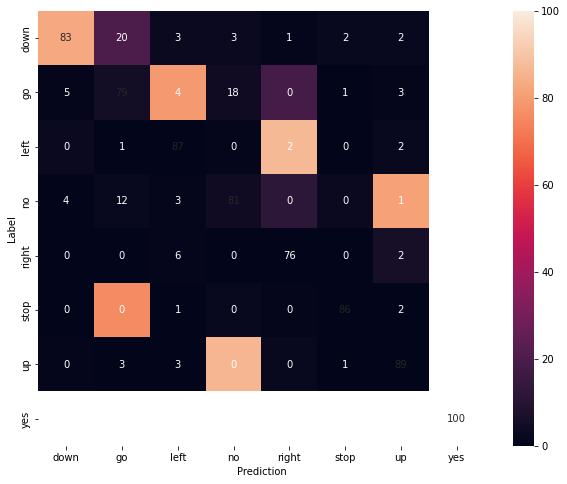

In [49]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferenza (cioè, previsione) di un nuovo file audio
<u>L'obbiettivo finale</u>: verificare la previsione del modello con **un NUOVO input file** (in questo esempio, un file di una persona che dice "no"). **Come performa il modello?**<br><br>
Utilizziamo la funzione di attivazione ***softmax*** per convertire le etichettte in probabilità:

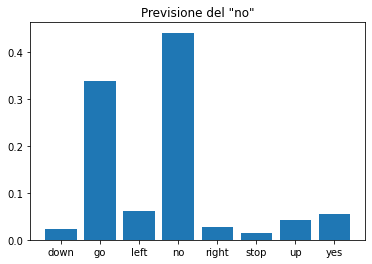

In [50]:
sample_file = data_dir/'no/0bde966a_nohash_0.wav'      # è un 'NO', come si vede dal path-name del file

sample_ds = preprocess_dataset([str(sample_file)])     # la trasformazione del file WAV in un spettrogramma e label intera.

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)                      # la previsione con il modello sopra costruito, di nome 'model'.
  plt.bar(commands, tf.nn.softmax(prediction[0]))      # la funzione 'softmax' produce le varie probabilità di classe.
  plt.title(f'Previsione del "{commands[label[0]]}"')
  plt.show()

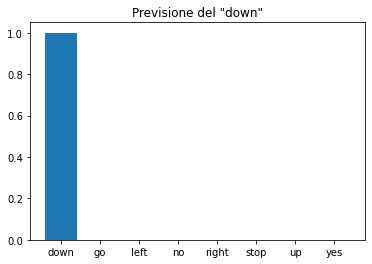

In [51]:
# secondo esempio
sample_file = data_dir/'down/00b01445_nohash_1.wav'      # è un 'DOWN', come si vede dal path-name del file

sample_ds = preprocess_dataset([str(sample_file)])     # la trasformazione del file WAV in un spettrogramma e label intera.

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)                      # la previsione con il modello sopra costruito, di nome 'model'.
  plt.bar(commands, tf.nn.softmax(prediction[0]))      # la funzione 'softmax' produce le varie probabilità di classe.
  plt.title(f'Previsione del "{commands[label[0]]}"')
  plt.show()

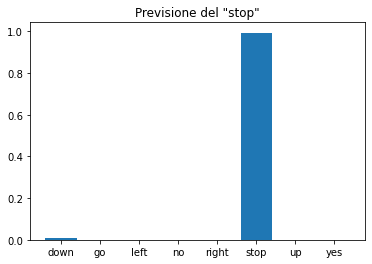

In [52]:
# terzo esempio
sample_file = data_dir/'stop/0b40aa8e_nohash_0.wav'      # è uno 'STOP', come si vede dal path-name del file

sample_ds = preprocess_dataset([str(sample_file)])     # la trasformazione del file WAV in un spettrogramma e label intera.

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)                      # la previsione con il modello sopra costruito, di nome 'model'.
  plt.bar(commands, tf.nn.softmax(prediction[0]))      # la funzione 'softmax' produce le varie probabilità di classe.
  plt.title(f'Previsione del "{commands[label[0]]}"')
  plt.show()

La funzione di attivazione *softmax* restituisce le probabilità di tutte le classi, per quel file audio.<br>
L'output suggerisce chiaramente che il modello ha riconosciuto il comando "no".

## Altro esempio?
Da [qui](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5).

## Passi successivi?
Questo notebook ha mostrato come fare una semplice classificazione audio / riconoscimento della voce automatiche con una CNN con TensorFlow/Keras.<b><br>
Altre risorse:
- il notebook [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) mostra come usare il *transfer learning* per la classificazione audio (cioè dei classificati pre-allenati, utilizzabili per tipologie di suoni comuni - l'equivalente del classificatore pre-allenato *ImageNet* per le immagini).
- i notebook della [sfida di Kaggle](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- il *codelab* https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0 mostra come costruire una webapp interattiva per la classificazione audio.
- Un [tutorial](https://arxiv.org/abs/1709.04396) sul deep learning per l'information retrieval musicale su arXiv.
- In generale, TensorFlow offre ulteriore supporto nella [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) come aiuto ai progetti *audio-based*.
- Da considerare anche la libreria [librosa](https://librosa.org/), un package Python per l'analisi di musica ed audio.